In [1]:
# ruff: noqa: F722
from dataclasses import dataclass
from datetime import datetime
from pathlib import Path
from functools import partial
from typing import Callable

import numpy as np
import jax
import jax.numpy as jnp
from jaxtyping import Float, Array
import pandas as pd
import equinox as eqx
import matplotlib.pyplot as plt

FloatScalar = Float[Array, ""]


@dataclass
class StockOptionData:
    """Dataclass containing the relevant information regarding the stock and option prices."""

    expiration_date: np.datetime64
    strike_price: float
    datestamps: np.ndarray
    stock_prices: np.ndarray
    price_ratios: np.ndarray
    call_prices: np.ndarray

    def num_business_days(self):
        return np.busday_count(self.datestamps[0], self.expiration_date)

    @property
    def normalized_time(self):
        return (
            jnp.arange(len(self.datestamps)) / 252
        )  # 252: (average) business days per year

    @property
    def normalized_stock(self):
        return self.stock_prices / self.strike_price

    @property
    def normalized_call(self):
        return self.call_prices / self.strike_price

    @property
    def normalized_expr_date(self):
        return self.num_business_days() / 252


def make_stockoption_data(
    stock_csv: Path,
    option_csv: Path,
    expiration_date: datetime | str,
    strike_price: float,
) -> StockOptionData:
    read_csv = partial(
        pd.read_csv, delimiter=",", parse_dates=[0], encoding="ascii", header=None
    )
    df_stock, df_option = read_csv(stock_csv), read_csv(option_csv)

    # Extract relevant information from the stock price csv
    stock_price, price_ratio = tuple(
        df_stock.iloc[::-1, idx].to_numpy() for idx in (1, 3)
    )
    option_price = df_option.iloc[::-1, -4].to_numpy()
    date_stock = df_stock.iloc[::-1, 0].values.astype(
        "datetime64[D]"
    )  # Hack to get the dates datetime64[D] type instead of the default datetime64[ns]
    # date_option = df_option.iloc[:,0].values.astype('datetime64[D]')
    # assert np.all(date_stock==date_option) is True, "The timestamps for the stock and option csvs do not match!"
    date_expir = (
        pd.to_datetime(expiration_date, format=r"%Y/%m/%d")
        .to_numpy()
        .astype("datetime64[D]")
    )
    return StockOptionData(
        date_expir, strike_price, date_stock, stock_price, price_ratio, option_price
    )


data = make_stockoption_data(
    "samsung_stock.csv", "samsung_2409_6e4.csv", "2024/09/12", 6e4
)

# 1. Visualize the stock and option prices over time

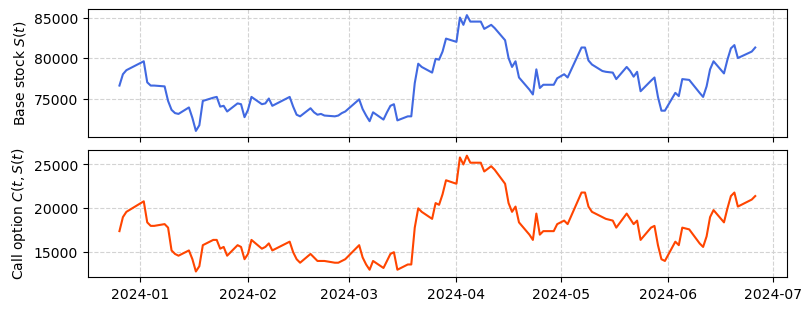

In [2]:
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True, constrained_layout=True)
axes[0].plot(data.datestamps, data.stock_prices, color="royalblue")
axes[0].set_ylabel("Base stock $S(t)$")
axes[1].plot(data.datestamps, data.call_prices, color="orangered")
axes[1].set_ylabel("Call option $C(t, S(t)$")
for ax in axes:
    ax.grid(ls="--", color="lightgray")

# Black-Scholes equation

\begin{equation}
\frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} -rC = 0
\end{equation}

Subject to the boundary conditions
\begin{align}
    &C(t, 0) = 0\\
    &C(t, S\rightarrow \infty) \rightarrow S-K\\
    &C(t=T, S) = \max(S-K, 0)
\end{align}

# 2. Normalize the dataset

\begin{equation}
\tilde{C} = C/K,\quad \tilde{S}= S/K
\end{equation}

All time units are in business years and $r$, $\sigma^2$ are in inverse business years (1 byr = 252 days).

The scaled equation becomes:

\begin{equation}
\frac{\partial \tilde{C}}{\partial t} + \frac{1}{2}\sigma^2 \tilde{S}^2 \frac{\partial^2 \tilde{C}}{\partial \tilde{S}^2} + rS\frac{\partial \tilde{C}}{\partial \tilde{S}} -r\tilde{C} = 0
\end{equation}

Subject to the boundary conditions
\begin{align}
    &\tilde{C}(t, 0) = 0\\
    &\tilde{C}(t, \tilde{S}\rightarrow \infty) \rightarrow \tilde{S}-1\\
    &\tilde{C}(t=T, \tilde{S}) = \max(\tilde{S}-1, 0)
\end{align}

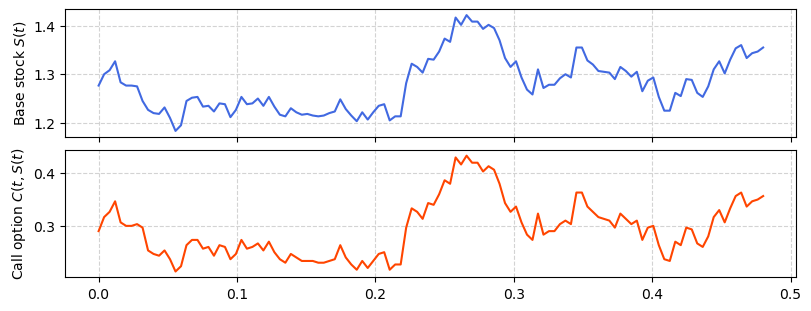

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(8, 3), sharex=True, constrained_layout=True)
axes[0].plot(data.normalized_time, data.normalized_stock, color="royalblue")
axes[0].set_ylabel("Base stock $S(t)$")
axes[1].plot(data.normalized_time, data.normalized_call, color="orangered")
axes[1].set_ylabel("Call option $C(t, S(t)$")
for ax in axes:
    ax.grid(ls="--", color="lightgray")

In [4]:
class BlackScholesParams(eqx.Module):
    """A equinox model to hold the coefficients of the Black-Scholes equation"""

    sigma: Float[Array, ""] = eqx.field(converter=jnp.asarray, default=1.0)
    r: Float[Array, ""] = eqx.field(converter=jnp.asarray, default=1.0)


class NN(eqx.Module):
    """A light wrapper around eqx.nn.MLP to make it into a two parameter function:
    NN = NN(t, S)"""

    net: eqx.nn.MLP

    def __init__(self, seed=0):
        rng_key = jax.random.PRNGKey(seed)
        self.net = eqx.nn.MLP(
            in_size=2,
            out_size="scalar",
            width_size=256,
            depth=2,
            activation=jax.nn.gelu,
            key=rng_key,
        )

    def __call__(self, t, S):
        tS = jnp.stack((t, S), axis=-1)
        return self.net(tS)


# Some helper functions for the partial differentiation


def D_t(f):
    r"""A functional computing $\frac{\partial f}{\partial t} (t, S)$"""

    @eqx.filter_grad
    def g(x, y):
        return f(x, y)

    return g


def D_x(f):
    r"""A functional computing $\frac{\partial f}{\partial S} (t, S)$"""

    def g(x, y):
        def _f(x_y):
            x, y = x_y
            return f(x, y)

        return eqx.filter_grad(_f)((x, y))[1]

    return g


def D_xx(f):
    return D_x(D_x(f))


net = NN()

print(D_t(net)(jnp.asarray(0.0), jnp.asarray(0.5)))
print(
    (
        net(jnp.asarray(0.0 + 1e-3), jnp.asarray(0.5))
        - net(jnp.asarray(0.0 - 1e-3), jnp.asarray(0.5))
    )
    / 2e-3
)

print(D_x(net)(jnp.asarray(0.0), jnp.asarray(0.5)))
print(
    (
        net(jnp.asarray(0.0), jnp.asarray(0.5 + 1e-3))
        - net(jnp.asarray(0.0), jnp.asarray(0.5 - 1e-3))
    )
    / 2e-3
)

-0.009642618
-0.009643844
0.0057369005
0.0057341526


In [5]:
def pde_residual_fn(
    C: Callable[[FloatScalar, FloatScalar], FloatScalar], params: BlackScholesParams
):
    @eqx.filter_vmap
    def _pde_residual(t, S):
        return (
            D_t(C)(t, S)
            + 0.5 * (params.sigma * S) ** 2 * D_xx(C)(t, S)
            + params.r * S * D_x(C)(t, S)
            - params.r * C(t, S)
        )

    return _pde_residual


def initval_residual_fn(C: Callable[[FloatScalar, FloatScalar], FloatScalar], T=1.0):
    @eqx.filter_vmap
    def _initval_residual(S):
        return C(T, S) - jax.nn.relu(S - 1.0)

    return _initval_residual


def zerobdry_residual_fn(C: Callable[[FloatScalar, FloatScalar], FloatScalar]):
    @eqx.filter_vmap
    def _zerobdry_residual(t):
        return C(t, jnp.asarray(0.0))

    return _zerobdry_residual


def inftybdry_residual_fn(
    C: Callable[[FloatScalar, FloatScalar], FloatScalar], S_infty=20.0
):
    @eqx.filter_vmap
    def _inftybdry_loss(t):
        return C(t, jnp.asarray(S_infty)) - (S_infty - 1.0)

    return _inftybdry_loss

In [6]:
def make_grid(
    data: StockOptionData,
    num_t_grid: int = 100,
    num_S_grid: int = 100,
    S_infty: float = 20.0,
):
    t_grid = jnp.linspace(
        data.normalized_time[0], data.normalized_expr_date, num_t_grid
    )
    S_grid = jnp.linspace(0, S_infty, num_S_grid)
    return t_grid, S_grid


t_grid, S_grid = make_grid(data)
t_mesh, S_mesh = jnp.meshgrid(t_grid, S_grid)

## Solve Black-Scholes equation for fixed dummy parameter values (sanity check)

In [7]:
def mean_squared(x: Array):
    return jnp.mean(x * x)


@eqx.filter_value_and_grad
def compute_loss(net_params, reduce_func=mean_squared):
    net, params = net_params

    pde_resid = pde_residual_fn(net, params)(t_mesh.reshape(-1), S_mesh.reshape(-1))

    zerobdry_resid = zerobdry_residual_fn(net)(t_grid)
    inftybdry_resid = inftybdry_residual_fn(net)(t_grid)

    initval_resid = initval_residual_fn(net)(S_grid)

    return (
        reduce_func(pde_resid)
        + reduce_func(zerobdry_resid)
        + reduce_func(inftybdry_resid)
        + reduce_func(initval_resid)
    )

In [10]:
import optax

learning_rate = 1e-4
optim = optax.adam(learning_rate)


@eqx.filter_jit
def make_step(model_params, opt_state):
    loss, grads = compute_loss(model_params)
    updates, opt_state = optim.update(grads, opt_state)
    model_params = eqx.apply_updates(model_params, updates)
    return loss, model_params, opt_state


net = NN()
params = BlackScholesParams(sigma=1.0, r=1.0)
params = jax.tree.map(
    float, params
)  # By making leaves of params float, they are held static during training

net_params = (net, params)
losses = []
n_epochs = 5000
opt_state = optim.init(eqx.filter(net_params, eqx.is_array))
for epoch in range(n_epochs):
    loss, net_params, opt_state = make_step(net_params, opt_state)
    loss = loss.item()
    print(f"epoch={epoch}, loss={loss}")
    losses.append(loss)

epoch=0, loss=445.1136169433594
epoch=1, loss=424.715576171875
epoch=2, loss=404.779541015625
epoch=3, loss=385.3180236816406
epoch=4, loss=366.3174743652344
epoch=5, loss=347.77191162109375
epoch=6, loss=329.7710876464844
epoch=7, loss=312.32147216796875
epoch=8, loss=295.35540771484375
epoch=9, loss=278.9447021484375
epoch=10, loss=263.03192138671875
epoch=11, loss=247.6695556640625
epoch=12, loss=232.85362243652344
epoch=13, loss=218.58413696289062
epoch=14, loss=204.8707733154297
epoch=15, loss=191.7100830078125
epoch=16, loss=179.1123046875
epoch=17, loss=167.059326171875
epoch=18, loss=155.56507873535156
epoch=19, loss=144.63856506347656
epoch=20, loss=134.23695373535156
epoch=21, loss=124.4041748046875
epoch=22, loss=115.07281494140625
epoch=23, loss=106.26110076904297
epoch=24, loss=97.96379089355469
epoch=25, loss=90.12161254882812
epoch=26, loss=82.76089477539062
epoch=27, loss=75.85936737060547
epoch=28, loss=69.3779525756836
epoch=29, loss=63.326019287109375
epoch=30, loss=

In [16]:
params

BlackScholesParams(sigma=1.0, r=1.0)

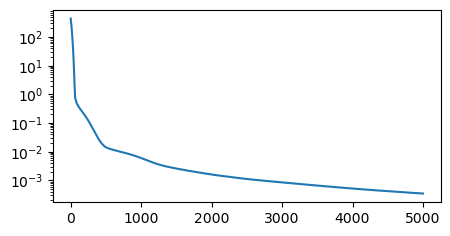

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.plot(losses)
ax.set_yscale("log", base=10)

In [13]:
C_pred = jax.vmap(net)(t_mesh.reshape(-1), S_mesh.reshape(-1)).reshape(t_mesh.shape)
C_pred.shape

(100, 100)

Text(0.5, 0, 'Option price $C(t, S)$')

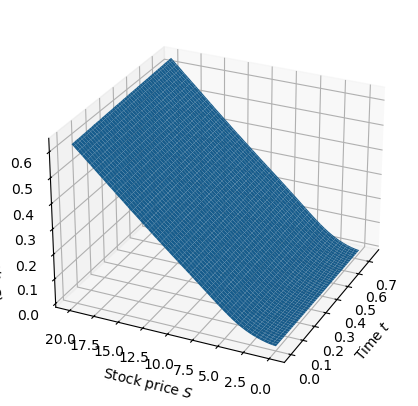

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection="3d"))
ax.plot_surface(t_mesh, S_mesh, C_pred)
ax.view_init(27, -155)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Stock price $S$")
ax.set_zlabel("Option price $C(t, S)$")

## Solve Black-Scholes equation and learn parameter values

In [21]:
t_data, S_data = data.normalized_time, data.normalized_stock
C_data = data.normalized_call


@eqx.filter_value_and_grad
def compute_loss(net_params, reduce_func=mean_squared):
    net, params = net_params

    pde_resid = pde_residual_fn(net, params)(t_mesh.reshape(-1), S_mesh.reshape(-1))

    zerobdry_resid = zerobdry_residual_fn(net)(t_grid)
    inftybdry_resid = inftybdry_residual_fn(net)(t_grid)

    initval_resid = initval_residual_fn(net)(S_grid)

    data_resid = eqx.filter_vmap(net)(t_data, S_data) - C_data
    return (
        reduce_func(pde_resid)
        + reduce_func(zerobdry_resid)
        + reduce_func(inftybdry_resid)
        + reduce_func(initval_resid)
        + reduce_func(data_resid)
    )

In [22]:
import optax

learning_rate = 1e-4
optim = optax.adam(learning_rate)


@eqx.filter_jit
def make_step(model_params, opt_state):
    loss, grads = compute_loss(model_params)
    updates, opt_state = optim.update(grads, opt_state)
    model_params = eqx.apply_updates(model_params, updates)
    return loss, model_params, opt_state


net = NN()
params = BlackScholesParams(sigma=1.0, r=1.0)

net_params = (net, params)
losses = []
sigmas = []
rs = []
n_epochs = 5000
opt_state = optim.init(eqx.filter(net_params, eqx.is_array))
for epoch in range(n_epochs):
    loss, net_params, opt_state = make_step(net_params, opt_state)
    loss = loss.item()
    params = net_params[1]
    sigmas.append(params.sigma)
    rs.append(params.r)
    print(f"epoch={epoch}, loss={loss}")
    losses.append(loss)

epoch=0, loss=445.1962585449219
epoch=1, loss=424.78948974609375
epoch=2, loss=404.84527587890625
epoch=3, loss=385.3759765625
epoch=4, loss=366.3680419921875
epoch=5, loss=347.81500244140625
epoch=6, loss=329.8084716796875
epoch=7, loss=312.35382080078125
epoch=8, loss=295.3818359375
epoch=9, loss=278.9666748046875
epoch=10, loss=263.049560546875
epoch=11, loss=247.68280029296875
epoch=12, loss=232.86436462402344
epoch=13, loss=218.5938262939453
epoch=14, loss=204.8793487548828
epoch=15, loss=191.7159881591797
epoch=16, loss=179.1162567138672
epoch=17, loss=167.0626678466797
epoch=18, loss=155.5686798095703
epoch=19, loss=144.6437530517578
epoch=20, loss=134.24266052246094
epoch=21, loss=124.41035461425781
epoch=22, loss=115.08236694335938
epoch=23, loss=106.2767562866211
epoch=24, loss=97.97969818115234
epoch=25, loss=90.13948822021484
epoch=26, loss=82.7850341796875
epoch=27, loss=75.88880157470703
epoch=28, loss=69.40806579589844
epoch=29, loss=63.36248016357422
epoch=30, loss=57.7

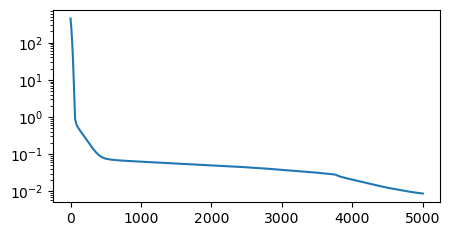

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))
ax.plot(losses)
ax.set_yscale("log", base=10)

Text(0, 0.5, '$r$')

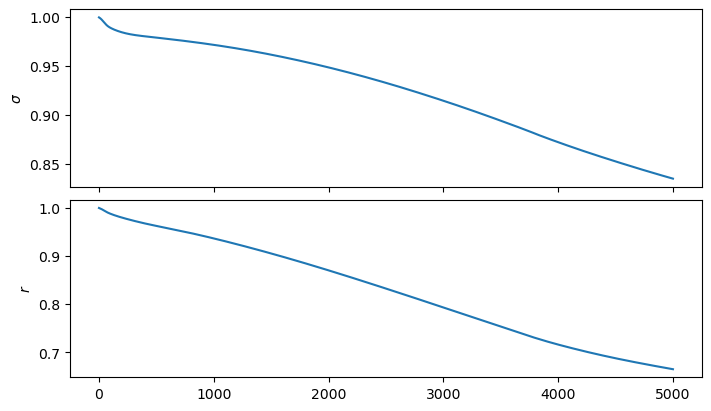

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(7, 4), sharex=True, constrained_layout=True)
axes[0].plot(sigmas)
axes[0].set_ylabel(r"$\sigma$")
axes[1].plot(rs)
axes[1].set_ylabel(r"$r$")
# ax.set_yscale("log", base=10)

Text(0.5, 0, 'Option price $C(t, S)$')

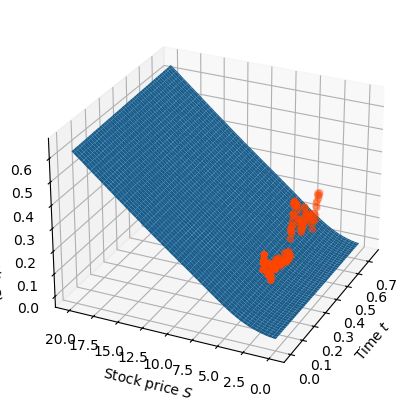

In [31]:
C_pred = jax.vmap(net)(t_mesh.reshape(-1), S_mesh.reshape(-1)).reshape(t_mesh.shape)
C_pred.shape

fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(projection="3d"))
ax.plot_surface(t_mesh, S_mesh, C_pred)
ax.scatter(t_data, S_data, C_data, color="orangered")
ax.view_init(27, -155)
ax.set_xlabel("Time $t$")
ax.set_ylabel("Stock price $S$")
ax.set_zlabel("Option price $C(t, S)$")